In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sodapy import Socrata
from urllib.request import urlopen
import json
import copy

#### Load PLUO data

In [2]:
# setup Socrata client, in this example we use generic, unauthenticated account
client = Socrata("data.cityofnewyork.us", None)
dataset_id = "64uk-42ks"

# Obtain the dataset as JSON from API by sodapy.
data = client.get(dataset_id, limit=900000, select='bbl, latitude, longitude') # from data description we know the data has 859K rows
# data = client.get(dataset_id, limit=30000, select="property_id, nyc_borough_block_and_lot_bbl") # select specific columns only

# Convert results to pandas DataFrame
pluto_df = pd.DataFrame.from_records(data)

In [3]:
pluto_df.head()

,bbl,latitude,longitude
0,3018090016.00000000,40.6871961,-73.9465987
1,3061830033.00000000,40.6145950,-73.9922993
2,3062060022.00000000,40.6125007,-73.9918421
3,3018520037.00000000,40.6818274,-73.9413030
4,3058930008.00000000,40.6320474,-74.0212816


In [4]:
pluto_df_ = pluto_df[~pluto_df.isnull().any(axis=1)]

In [5]:
#geo dataframe
#points
pluto_gdf = gpd.GeoDataFrame(pluto_df_, geometry=gpd.points_from_xy(pluto_df_.longitude, pluto_df_.latitude))

In [6]:
pluto_gdf.head()

,bbl,latitude,longitude,geometry
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720)
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460)
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250)
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183)
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205)


In [7]:
pluto_gdf = pluto_gdf.set_crs(4326)

In [8]:
#sanity check
len(pluto_gdf)

857579

In [9]:
#sanity check
#bbl should be the unique identifier
len(pluto_gdf['bbl'].unique())

857579

#### Load floodplain data

In [10]:
#floodplain
fp_500 = gpd.read_file('../Data/fp_500yr/geo_export_f9627ca8-5409-4bf4-9e1c-e812fdb2e4d7.shp')
fp_500 = fp_500.set_crs(4326, allow_override=True)

In [11]:
fp_500.head()

,abfe_0_2pc,fld_zone,gridcode,join_count,shape_area,shape_leng,static_bfe,geometry
0,0.0,NaN,1500.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.90993 40.91517, -73.91010 40.915..."
1,0.0,NaN,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88825 40.89957, -73.88801 40.899..."
2,0.0,NaN,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88852 40.89902, -73.88846 40.899..."
3,0.0,NaN,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88861 40.89875, -73.88861 40.899..."
4,0.0,NaN,1300.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.88861 40.89861, -73.88874 40.898..."


<Axes: >

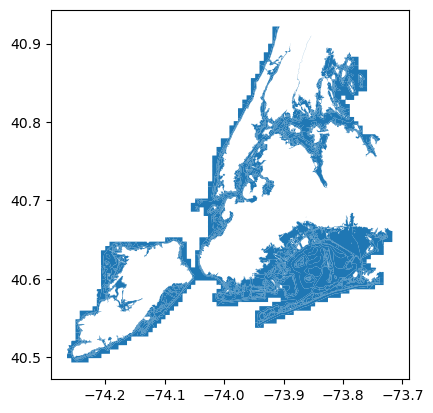

In [12]:
fp_500.plot()

In [13]:
fp_500['fld_zone'].unique()

array([nan, 'AE', 'VE', 'AO'], dtype=object)

<Axes: >

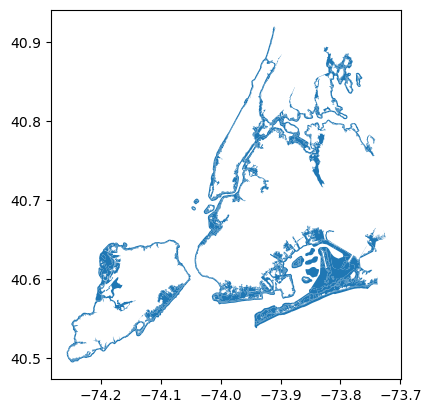

In [14]:
#only select rows with a designated flood zone
fp_500_z = fp_500.loc[(fp_500['fld_zone'] == 'AE') | (fp_500['fld_zone'] == 'VE') | (fp_500['fld_zone'] == 'AO')]
fp_500_z.plot()

#### Use the overlay() function (https://geopandas.org/en/stable/docs/user_guide/set_operations.html) to calculate intersection of PLUTO points and floodplain polygons

In [15]:
comb = gpd.overlay(pluto_gdf, fp_500_z, how='intersection')
comb = comb.drop_duplicates('bbl')
comb['col_1'] = 1
print(len(comb))
comb.head()

54777


,bbl,latitude,longitude,abfe_0_2pc,fld_zone,gridcode,join_count,shape_area,shape_leng,static_bfe,geometry,col_1
0,3068680068.00000000,40.5959958,-73.9871882,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98719 40.59600),1
1,3071610044.00000000,40.5894214,-73.9826421,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98264 40.58942),1
2,3069190097.00000000,40.5855652,-73.9844576,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98446 40.58557),1
3,3068660077.00000000,40.5965147,-73.9890642,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98906 40.59651),1
4,3068670069.00000000,40.5961825,-73.9881640,14.0,AE,1400.0,2.0,1.075891e+07,54372.827437,10.0,POINT (-73.98816 40.59618),1


In [16]:
#use the bbl column to join back to original pluto_gdf
df1 = pluto_gdf.merge(comb[['bbl', 'col_1']], how = 'left',
                left_on = 'bbl', right_on = 'bbl')
df1 = df1.drop_duplicates('bbl', keep='first')
df1.head()

,bbl,latitude,longitude,geometry,col_1
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),NaN
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460),NaN
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250),NaN
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),NaN
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205),NaN


In [17]:
#sanity check
print(df1.shape)
print(df1['col_1'].notna().sum())
print(df1['col_1'].isna().sum())

(857579, 5)
54777
802802


In [18]:
#in_fz column: 0 not in flood zone; 1 in flood zone
df1['col_1'] = df1['col_1'].replace(np.nan, 0)
df1 = df1.rename(columns={'col_1': 'in_fz'})
df1['in_fz'] = df1['in_fz'].astype(int)
df1.head()

,bbl,latitude,longitude,geometry,in_fz
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),0
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460),0
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250),0
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),0
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205),0


In [19]:
print(df1['in_fz'].notna().sum())

857579


In [20]:
# #save output
# #shp
# df1.to_file('../Data/pluto_floodplain/pluto_floodplain.shp')

In [21]:
# #csv
# df1.to_csv('../Data/pluto_floodplain.csv', index=False)

#### Add nta designation to every PLUTO point

In [22]:
#open pluto flood df
pluto = df1.copy()
pluto.head()

,bbl,latitude,longitude,geometry,in_fz
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),0
1,3061830033.00000000,40.6145950,-73.9922993,POINT (-73.99230 40.61460),0
2,3062060022.00000000,40.6125007,-73.9918421,POINT (-73.99184 40.61250),0
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),0
4,3058930008.00000000,40.6320474,-74.0212816,POINT (-74.02128 40.63205),0


In [23]:
#check crs
pluto.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
#open nta 
nta = gpd.read_file('../Data/nta_2010/geo_export_d66993ca-6cc0-4ee0-9b66-052e7675b5f0.shp')
nta = nta.to_crs(4326)
nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."
2,4.0,Queens,081,QN55,South Ozone Park,8.246139e+07,36708.169305,"POLYGON ((-73.80577 40.68293, -73.80552 40.682..."
3,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661..."
4,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [25]:
#check crs
nta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
#spatial join and add the nta columns to each pluto point
pluto_nta = pluto.sjoin(nta, how='inner', predicate='intersects')
pluto_nta.head()

,bbl,latitude,longitude,geometry,in_fz,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),0,18,3.0,Brooklyn,047,BK75,Bedford,3.262979e+07,29992.924096
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),0,18,3.0,Brooklyn,047,BK75,Bedford,3.262979e+07,29992.924096
12,3018140073.00000000,40.6860984,-73.9471080,POINT (-73.94711 40.68610),0,18,3.0,Brooklyn,047,BK75,Bedford,3.262979e+07,29992.924096
13,3018190050.00000000,40.6855730,-73.9446313,POINT (-73.94463 40.68557),0,18,3.0,Brooklyn,047,BK75,Bedford,3.262979e+07,29992.924096
14,3018190003.00000000,40.6853764,-73.9469138,POINT (-73.94691 40.68538),0,18,3.0,Brooklyn,047,BK75,Bedford,3.262979e+07,29992.924096


In [28]:
pluto_nta = pluto_nta.iloc[:, [0,1,2,3,4,6,7,8,9,10]]
pluto_nta.head()

,bbl,latitude,longitude,geometry,in_fz,boro_code,boro_name,county_fip,ntacode,ntaname
0,3018090016.00000000,40.6871961,-73.9465987,POINT (-73.94660 40.68720),0,3.0,Brooklyn,047,BK75,Bedford
3,3018520037.00000000,40.6818274,-73.9413030,POINT (-73.94130 40.68183),0,3.0,Brooklyn,047,BK75,Bedford
12,3018140073.00000000,40.6860984,-73.9471080,POINT (-73.94711 40.68610),0,3.0,Brooklyn,047,BK75,Bedford
13,3018190050.00000000,40.6855730,-73.9446313,POINT (-73.94463 40.68557),0,3.0,Brooklyn,047,BK75,Bedford
14,3018190003.00000000,40.6853764,-73.9469138,POINT (-73.94691 40.68538),0,3.0,Brooklyn,047,BK75,Bedford


In [29]:
pluto_nta.isna().sum()

bbl           0
latitude      0
longitude     0
geometry      0
in_fz         0
boro_code     0
boro_name     0
county_fip    0
ntacode       0
ntaname       0
dtype: int64

In [30]:
len(pluto)

857579

In [31]:
len(pluto_nta)

856350

It seems that some of the pluto points didn't have an nta...

In [32]:
#save the spatial join result
pluto_nta.to_file('../Data/pluto_flood_nta/pluto_flood_nta.shp')

In [33]:
#save as csv
pluto_nta.to_csv('../Data/pluto_flood_nta.csv', index=False)